###Entrainement du modèle




=== 4.1. Préparation des données pour la classification ===
Chargement des données...
Fichier CSV chargé avec succès.
Taille initiale : (229185, 18)

Inspection des valeurs non numériques :

Vérification des doublons :
Doublons (caractéristiques + cible) : 219260
Taille après suppression des doublons : (9925, 18)
Taille après filtrage des classes rares : (9925, 18)

Gestion des valeurs manquantes...

Valeurs manquantes après traitement :
Length    0
Draft     0
SOG       0
Width     0
dtype: int64

Types des caractéristiques :
Length    float64
Draft     float64
SOG       float64
Width     float64
dtype: object

Corrélations :


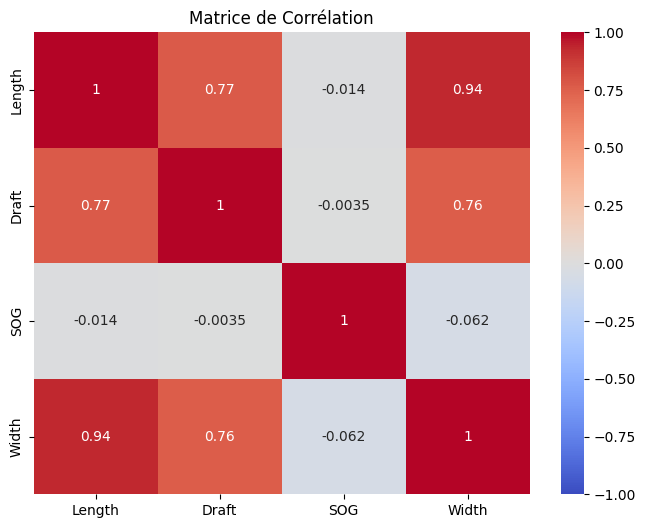

Corrélation :
           Length     Draft       SOG     Width
Length  1.000000  0.766210 -0.014092  0.935044
Draft   0.766210  1.000000 -0.003513  0.760740
SOG    -0.014092 -0.003513  1.000000 -0.061635
Width   0.935044  0.760740 -0.061635  1.000000

Analyse du dataset :
Taille : (9925, 18)
Nombre de classes : 3
Distribution des classes :
VesselType
Tanker       0.455718
Cargo        0.423476
Passenger    0.120806
Name: proportion, dtype: float64
Valeurs uniques : ['Tanker' 'Passenger' 'Cargo']

=== 4.2. Apprentissage supervisé ===
Encodage de la cible...
Encodeur sauvegardé dans 'label_encoder.pkl'
Exemple d'encodage : {'Cargo': 0, 'Passenger': 1, 'Tanker': 2}

Division des données...
Taille de l'entraînement : 7940 échantillons
Taille du test : 1985 échantillons

Création du pipeline...

Hyperparamètres testés :
{'classifier__n_estimators': [100], 'classifier__max_depth': [10, 20], 'classifier__min_samples_split': [5, 10], 'classifier__min_samples_leaf': [2, 5], 'classifier__class_we

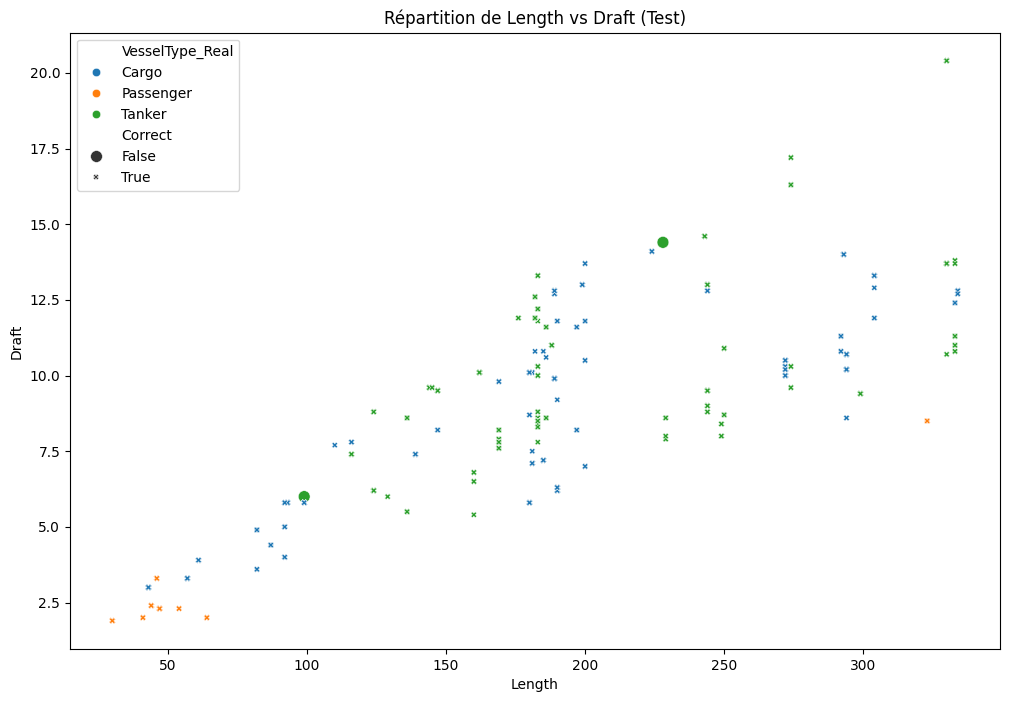


Rapport de classification (test) :
              precision    recall  f1-score   support

       Cargo       1.00      1.00      1.00       826
   Passenger       1.00      1.00      1.00       250
      Tanker       1.00      1.00      1.00       909

    accuracy                           1.00      1985
   macro avg       1.00      1.00      1.00      1985
weighted avg       1.00      1.00      1.00      1985


Matrice de confusion :


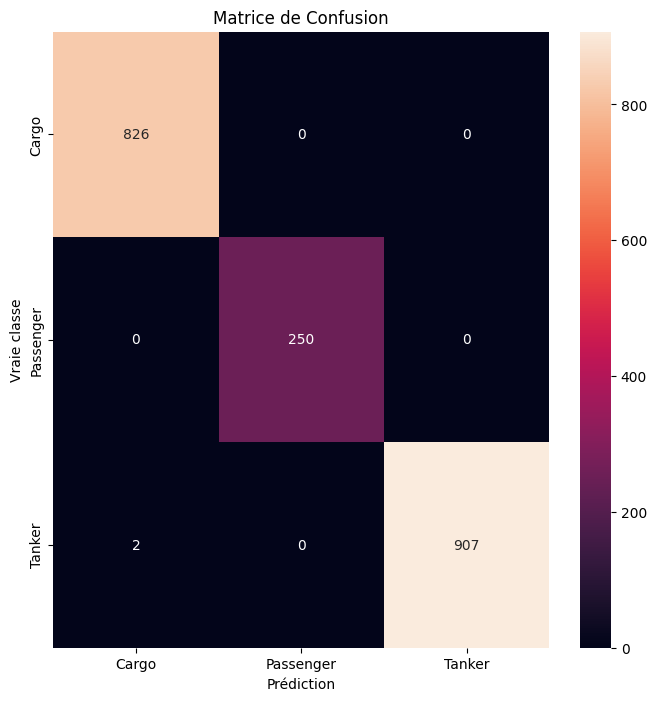


Importance des caractéristiques :
  Feature  Importance
0  Length    0.385377
1   Draft    0.368417
3   Width    0.236979
2     SOG    0.009227


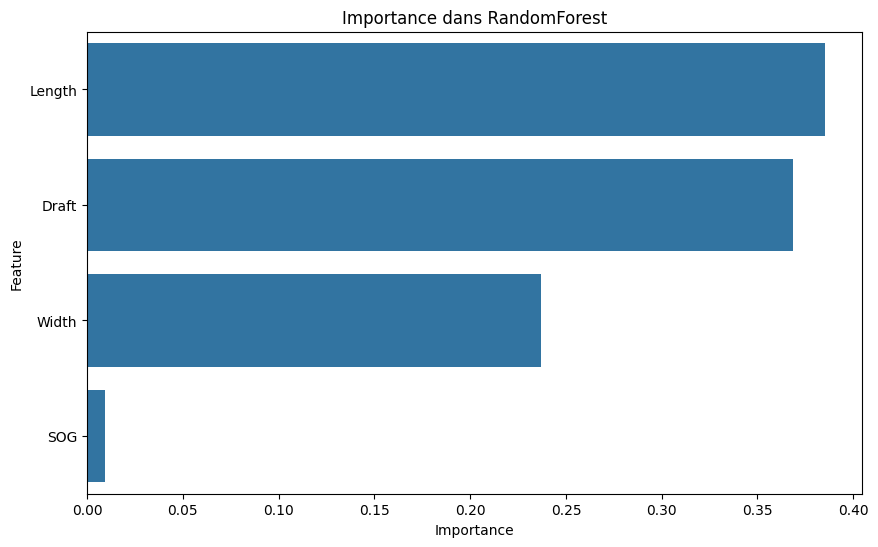

In [11]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 4.1. Préparation des données pour la classification ===
print("\n=== 4.1. Préparation des données pour la classification ===")

# Définir les colonnes et types
features = ['Length', 'Draft', 'SOG', 'Width']
target = 'VesselType'
dtype_dict = {col: float for col in features}
dtype_dict[target] = str

# Charger les données
print("Chargement des données...")
try:
    data = pd.read_csv('export_IA.csv', dtype=dtype_dict, on_bad_lines='skip', low_memory=False)
    print("Fichier CSV chargé avec succès.")
except Exception as e:
    print(f"Erreur lors de la lecture du CSV : {e}")
    raise

print(f"Taille initiale : {data.shape}")

# Vérifier les colonnes
if not all(col in data.columns for col in features + [target]):
    missing_cols = [col for col in features + [target] if col not in data.columns]
    raise ValueError(f"Colonnes manquantes : {missing_cols}")

# Inspecter les valeurs non numériques
print("\nInspection des valeurs non numériques :")
for col in features:
    non_numeric = data[pd.to_numeric(data[col], errors='coerce').isna()][col].unique()
    if len(non_numeric) > 0:
        print(f"Valeurs non numériques dans {col} : {non_numeric}")

# Supprimer les doublons
print("\nVérification des doublons :")
print(f"Doublons (caractéristiques + cible) : {data.duplicated(subset=features + [target]).sum()}")
data = data.drop_duplicates(subset=features + [target])
print(f"Taille après suppression des doublons : {data.shape}")

# Nettoyer VesselType avec mappage AIS
vessel_type_mapping = {
    '60': 'Passenger', '60.0': 'Passenger', '61': 'Passenger', '61.0': 'Passenger',
    '70': 'Cargo', '70.0': 'Cargo', '71': 'Cargo', '71.0': 'Cargo',
    '74': 'Cargo', '74.0': 'Cargo', '79': 'Cargo', '79.0': 'Cargo',
    '80': 'Tanker', '80.0': 'Tanker', '82': 'Tanker', '82.0': 'Tanker',
    '84': 'Tanker', '84.0': 'Tanker', '89': 'Tanker', '89.0': 'Tanker',
    '0.0': 'Unknown', '1': 'Unknown', '12.2': 'Unknown', '12.4': 'Unknown',
    '162.0': 'Unknown', '169': 'Unknown', '2.3': 'Unknown', '333.0': 'Unknown',
    '46.0': 'Unknown', 'Cargo': 'Cargo', 'Tanker': 'Tanker', 'Passenger': 'Passenger'
}
data['VesselType'] = data['VesselType'].astype(str).replace(vessel_type_mapping).fillna('Unknown').astype(str)

# Filtrer les classes rares
class_counts = data['VesselType'].value_counts()
valid_classes = class_counts[class_counts >= 100].index
data = data[data['VesselType'].isin(valid_classes)]
print(f"Taille après filtrage des classes rares : {data.shape}")

# Extraire X et y
X = data[features]
y = data[target]

# Gérer les valeurs manquantes
print("\nGestion des valeurs manquantes...")
for col in features:
    X.loc[:, col] = X[col].fillna(X[col].median())
    if col == 'Heading':
        X.loc[:, col] = X[col] % 360

print("\nValeurs manquantes après traitement :")
print(X.isna().sum())

# Vérifier les types
print("\nTypes des caractéristiques :")
print(X.dtypes)

# Vérifier les corrélations
print("\nCorrélations :")
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation")
plt.show()
print("Corrélation :\n", correlation_matrix)

# Analyse du dataset
print("\nAnalyse du dataset :")
print(f"Taille : {data.shape}")
print(f"Nombre de classes : {y.nunique()}")
print(f"Distribution des classes :\n{y.value_counts(normalize=True)}")
print(f"Valeurs uniques : {y.unique()}")

# === 4.2. Apprentissage supervisé ===
print("\n=== 4.2. Apprentissage supervisé ===")

# Encoder la cible
print("Encodage de la cible...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Encodeur sauvegardé dans 'label_encoder.pkl'")
print("Exemple d'encodage :", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Diviser les données
print("\nDivision des données...")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(f"Taille de l'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille du test : {X_test.shape[0]} échantillons")

# Configurer le pipeline
print("\nCréation du pipeline...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalisation des caractéristiques
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grille d'hyperparamètres réduite pour limiter la RAM
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 5],
    'classifier__class_weight': ['balanced']
}
print("\nHyperparamètres testés :")
print(param_grid)

# Recherche aléatoire
print("\nEntraînement avec RandomizedSearchCV...")
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=5, cv=3, scoring='accuracy', n_jobs=1, random_state=42)
random_search.fit(X_train, y_train)

# Résultats
print(f"\nMeilleurs paramètres : {random_search.best_params_}")
print(f"Accuracy moyenne (validation croisée) : {random_search.best_score_:.4f}")

# Validation croisée
print("\nValidation croisée (5 plis) :")
scores = cross_val_score(random_search.best_estimator_, X, y_encoded, cv=5, scoring='accuracy', n_jobs=1)
print(f"Scores : {scores}")
print(f"Accuracy moyenne : {scores.mean():.4f}")
print(f"Écart-type : {scores.std():.4f}")

# Sauvegarder le modèle
final_model = random_search.best_estimator_
joblib.dump(final_model, 'final_random_forest_model.pkl')
print("Modèle sauvegardé dans 'final_random_forest_model.pkl'")

# === 4.3. Évaluation des performances ===
print("\n=== 4.3. Évaluation des performances ===")

# Prédictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy entraînement : {train_accuracy:.4f}")
print(f"Accuracy test : {test_accuracy:.4f}")
print(f"Écart train/test : {train_accuracy - test_accuracy:.4f}")

# Résultats d'entraînement
print("\nDonnées et prédictions (entraînement) :")
train_results = X_train.copy()
train_results['VesselType_Real'] = label_encoder.inverse_transform(y_train)
train_results['VesselType_Pred'] = label_encoder.inverse_transform(y_train_pred)
train_results['Correct'] = y_train == y_train_pred
print("\nÉchantillon (10 premières lignes) :")
print(train_results.head(10))
print(f"\nErreurs (entraînement) : {(~train_results['Correct']).sum()}")
train_results.to_csv('train_predictions.csv', index=False)
print("Résultats sauvegardés dans 'train_predictions.csv'")

# Résultats de test
print("\nDonnées et prédictions (test) :")
test_results = X_test.copy()
test_results['VesselType_Real'] = label_encoder.inverse_transform(y_test)
test_results['VesselType_Pred'] = label_encoder.inverse_transform(y_test_pred)
test_results['Correct'] = y_test == y_test_pred
print("\nÉchantillon (10 premières lignes) :")
print(test_results.head(10))
print(f"\nErreurs (test) : {(~test_results['Correct']).sum()}")
test_results.to_csv('test_predictions.csv', index=False)
print("Résultats sauvegardés dans 'test_predictions.csv'")

# Analyse des erreurs
print("\nAnalyse des erreurs (test) :")
errors = test_results[test_results['Correct'] == False][['VesselType_Real', 'VesselType_Pred']].value_counts()
print("Erreurs (VesselType_Real -> VesselType_Pred) :")
print(errors.head(10))

# Visualisation (Length vs Draft)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Length', y='Draft', hue='VesselType_Real', style='Correct', size='Correct', data=test_results)
plt.title("Répartition de Length vs Draft (Test)")
plt.show()

# Rapport de classification
print("\nRapport de classification (test) :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, zero_division=0))

# Matrice de confusion
print("\nMatrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.show()

# Importance des caractéristiques
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': final_model.named_steps['classifier'].feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nImportance des caractéristiques :")
print(feature_importances)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Importance dans RandomForest")
plt.show()

###Script automatisé

In [12]:
import pandas as pd
import joblib
import numpy as np

# Charger les modèles préenregistrés
model = joblib.load('final_random_forest_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Définir les plages réalistes (à ajuster selon ton dataset)
value_ranges = {
    'Length': (0, 400),    # Longueur en mètres
    'Draft': (0, 20),      # Tirant d'eau en mètres
    'SOG': (0, 30),        # Speed Over Ground en nœuds (0 à 30 nœuds typique)
    'Width': (0, 60)       # Largeur en mètres (0 à 60 m, basé sur navires typiques)
}

# Fonction pour obtenir une entrée valide
def get_valid_input(prompt, data_type, range_min_max):
    while True:
        try:
            value = data_type(input(prompt))
            if not (range_min_max[0] <= value <= range_min_max[1]):
                print(f"Erreur : {value} est hors de la plage [{range_min_max[0]}, {range_min_max[1]}]. Veuillez réessayer.")
                continue
            return value
        except ValueError:
            print("Erreur : Veuillez entrer un nombre valide.")

# Collecter les données
print("Veuillez entrer les caractéristiques du navire :")
data = {
    'Length': get_valid_input("Longueur (m) [0-400] : ", float, value_ranges['Length']),
    'Draft': get_valid_input("Tirant d'eau (m) [0-20] : ", float, value_ranges['Draft']),
    'SOG': get_valid_input("Vitesse (nœuds) [0-30] : ", float, value_ranges['SOG']),
    'Width': get_valid_input("Largeur (m) [0-60] : ", float, value_ranges['Width'])
}

# Convertir en DataFrame
new_data = pd.DataFrame([data])
new_data = new_data.fillna(new_data.median())

# Prédire
predictions_encoded = model.predict(new_data)
predictions = label_encoder.inverse_transform(predictions_encoded)
predicted_type = predictions[0]
print(f"\nType de navire prédit : {predicted_type}")

Veuillez entrer les caractéristiques du navire :
Longueur (m) [0-400] : 7
Tirant d'eau (m) [0-20] : 5
Vitesse (nœuds) [0-30] : 8
Largeur (m) [0-60] : 9

Type de navire prédit : Cargo
